# Factorial Machine Classification with Heart Disease Data Set
Factorial Machine (FM) is a supervised learning algorithm that can be used for classification problems. It is a type of factorization machine that uses feature interactions to predict the target variable. The FM algorithm has been shown to be effective in a variety of applications, including recommender systems, natural language processing, and bioinformatics.

In this Jupyter notebook, we will explore how to use FM for classification problems using PySpark. Specifically, we will use the Heart Disease dataset, which contains information about patients with and without heart disease, to build an FM model that can predict whether a patient has heart disease based on their physical characteristics. We will cover the following topics:

- Loading and preparing the data
- Training an FM model using PySpark's MLlib library
- Evaluating the model's performance using various metrics
- Tuning the model's hyperparameters to improve its performance

By the end of this notebook, you should have a good understanding of how Factorial Machine works and how to apply it to real-world classification problems using PySpark.

## Introduction

### Description of Heart Disease dataset

The Heart Disease dataset is a collection of medical data from patients with suspected heart disease. It contains various attributes such as age, sex, blood pressure, and cholesterol levels, among others, as well as the presence or absence of heart disease. This dataset is commonly used for classification tasks in machine learning and is often used to predict the presence of heart disease in patients based on their medical history and physical characteristics. The dataset has been extensively studied and is a popular benchmark dataset in the machine learning community.

### Importing necessery libraries and download the dataset

In this section, we will import the required libraries and download the Heart Disease dataset.

#### Importing Libraries
We will begin by importing the necessary libraries required for our analysis. These include:

- SparkSession: used for start and mantain a spark session
- VectorAssembler: used for transform the dataset in something meaninful to spark
- StandardScaler: used for scaler the dataset
- FMClassifier: used for construct the model
- Pipeline: used for create a pipeline
- skelearn: only used here to easy create a confusion matrix
- ParamGridBuilder: used for tuning the hyperparams of the model
- TrainValidationSplit: used for crossvalidation and select best hyperparams
- matplotlib: used for data visualization

In [83]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.classification import FMClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn import metrics
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.sql.functions import when

#### Downloading the Heart Disease dataset
Next, we will download the Heart Disease dataset using the curl command. The dataset is available in a CSV format and will be stored in a pandas dataframe for further analysis. We will also print out some summary statistics of the dataset to gain a better understanding of its structure and features.

Each column represents the following information:

- age: age of the patient
- sex: sex of the patient (1 = male; 0 = female)
- cp: chest pain type (0 = typical angina; 1 = atypical angina; 2 = non-anginal pain; 3 = asymptomatic)
- trestbps: resting blood pressure (in mm Hg)
- chol: serum cholesterol (in mg/dl)
- fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- restecg: resting electrocardiographic results (0 = normal; 1 = having ST-T wave abnormality; 2 = showing probable or definite left ventricular hypertrophy)
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment (0 = upsloping; 1 = flat; 2 = downsloping)
- ca: number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- target: presence of heart disease (0 = absence, 1-4 = presence, representing different degrees of severity)

In [2]:
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data  --output heart.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18461  100 18461    0     0  15176      0  0:00:01  0:00:01 --:--:-- 15181


In [64]:
schema_heart = 'age FLOAT, sex FLOAT, cp FLOAT, trestbps FLOAT, chol FLOAT, fbs FLOAT, restecg FLOAT, thalach FLOAT, exang FLOAT, oldpeak FLOAT, slope FLOAT, ca FLOAT, thal FLOAT, target FLOAT'

# init SparkSession
spark = SparkSession.builder.appName('FMClassifier').getOrCreate()
# read the csv using pyspark
heart = spark.read.csv('./heart.csv', schema=schema_heart, header=False)

# print few lines of the dataframe
heart.show(5)

+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+------+
| age|sex| cp|trestbps| chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+------+
|63.0|1.0|1.0|   145.0|233.0|1.0|    2.0|  150.0|  0.0|    2.3|  3.0|0.0| 6.0|   0.0|
|67.0|1.0|4.0|   160.0|286.0|0.0|    2.0|  108.0|  1.0|    1.5|  2.0|3.0| 3.0|   2.0|
|67.0|1.0|4.0|   120.0|229.0|0.0|    2.0|  129.0|  1.0|    2.6|  2.0|2.0| 7.0|   1.0|
|37.0|1.0|3.0|   130.0|250.0|0.0|    0.0|  187.0|  0.0|    3.5|  3.0|0.0| 3.0|   0.0|
|41.0|0.0|2.0|   130.0|204.0|0.0|    2.0|  172.0|  0.0|    1.4|  1.0|0.0| 3.0|   0.0|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+------+
only showing top 5 rows



## Exploratory Data Analysis

### Summary statistics of the dataset

In this section, we will explore the iris datasets giving some statistic description like mean, std, etc.

In [69]:
from pyspark.sql.functions import round
heart.describe().select(['summary'] + [round(c, 2).alias(c) for c in heart.columns]).show()

+-------+-----+-----+-----+--------+------+-----+-------+-------+-----+-------+-----+-----+-----+------+
|summary|  age|  sex|   cp|trestbps|  chol|  fbs|restecg|thalach|exang|oldpeak|slope|   ca| thal|target|
+-------+-----+-----+-----+--------+------+-----+-------+-------+-----+-------+-----+-----+-----+------+
|  count|303.0|303.0|303.0|   303.0| 303.0|303.0|  303.0|  303.0|303.0|  303.0|303.0|299.0|301.0| 303.0|
|   mean|54.44| 0.68| 3.16|  131.69|246.69| 0.15|   0.99| 149.61| 0.33|   1.04|  1.6| 0.67| 4.73|  0.94|
| stddev| 9.04| 0.47| 0.96|    17.6| 51.78| 0.36|   0.99|  22.88| 0.47|   1.16| 0.62| 0.94| 1.94|  1.23|
|    min| 29.0|  0.0|  1.0|    94.0| 126.0|  0.0|    0.0|   71.0|  0.0|    0.0|  1.0|  0.0|  3.0|   0.0|
|    max| 77.0|  1.0|  4.0|   200.0| 564.0|  1.0|    2.0|  202.0|  1.0|    6.2|  3.0|  3.0|  7.0|   4.0|
+-------+-----+-----+-----+--------+------+-----+-------+-------+-----+-------+-----+-----+-----+------+



We want only to detect if the target pacient has or no a heart desease then we will change the target colunm

In [75]:
heart = heart.withColumn("target_binary", when(heart["target"] != 0, 1).otherwise(0))

In [76]:
train, test = heart.randomSplit([0.8, 0.2])

### Preprocessing the data (e.g., scaling, normalization, encoding)

Here we will use the RFormula to separate and treat the dataframe and the MinMaxScaller

In [78]:
formula = RFormula(formula='target_binary ~ . - target', featuresCol='features', labelCol='label', handleInvalid = "skip")
# only to see if everything is ok
formula.fit(train).transform(train).select('features', 'label').show(5, truncate=False)

+--------------------------------------------------------------------------+-----+
|features                                                                  |label|
+--------------------------------------------------------------------------+-----+
|[29.0,1.0,2.0,130.0,204.0,0.0,2.0,202.0,0.0,0.0,1.0,0.0,3.0]              |0.0  |
|[34.0,0.0,2.0,118.0,210.0,0.0,0.0,192.0,0.0,0.699999988079071,1.0,0.0,3.0]|0.0  |
|[34.0,1.0,1.0,118.0,182.0,0.0,2.0,174.0,0.0,0.0,1.0,0.0,3.0]              |0.0  |
|[35.0,0.0,4.0,138.0,183.0,0.0,0.0,182.0,0.0,1.399999976158142,1.0,0.0,3.0]|0.0  |
|[35.0,1.0,2.0,122.0,192.0,0.0,0.0,174.0,0.0,0.0,1.0,0.0,3.0]              |0.0  |
+--------------------------------------------------------------------------+-----+
only showing top 5 rows



In [79]:
# IMPORTANT only fit the scaler using the training set
temp = formula.fit(train).transform(train)
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', )
# only to see if everything is ok
scaler.fit(temp).transform(temp).select('features', 'scaledFeatures').show()

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[29.0,1.0,2.0,130...|[3.24909286489608...|
|[34.0,0.0,2.0,118...|[3.80928128987816...|
|[34.0,1.0,1.0,118...|[3.80928128987816...|
|[35.0,0.0,4.0,138...|[3.92131897487458...|
|[35.0,1.0,2.0,122...|[3.92131897487458...|
|[35.0,1.0,4.0,126...|[3.92131897487458...|
|(13,[0,2,3,4,7,10...|(13,[0,2,3,4,7,10...|
|[37.0,1.0,3.0,130...|[4.14539434486741...|
|(13,[0,2,3,4,7,10...|(13,[0,2,3,4,7,10...|
|[39.0,1.0,3.0,140...|[4.36946971486025...|
|[39.0,1.0,4.0,118...|[4.36946971486025...|
|[40.0,1.0,1.0,140...|[4.48150739985666...|
|[40.0,1.0,4.0,152...|[4.48150739985666...|
|[41.0,0.0,2.0,105...|[4.59354508485308...|
|(13,[0,2,3,4,7,10...|(13,[0,2,3,4,7,10...|
|[41.0,0.0,2.0,130...|[4.59354508485308...|
|[41.0,0.0,3.0,112...|[4.59354508485308...|
|[41.0,1.0,2.0,110...|[4.59354508485308...|
|[41.0,1.0,2.0,120...|[4.59354508485308...|
|[41.0,1.0,2.0,135...|[4.5935450

## Model Training
 Here we will build the model and create the pipeline that will be trained
 
### Building a FM Classification

In [80]:
fm = FMClassifier(labelCol="label", featuresCol="scaledFeatures", stepSize=0.001)

In [81]:
# building all together
pipeline = Pipeline(stages=[formula, scaler, fm])

### Training the model on the training set

In [82]:
model = pipeline.fit(train)

### Evaluating the performance of the model on the test set 

In [86]:
prd = model.transform(test)

evaluator = BinaryClassificationEvaluator()

# Area under precision-recall curve
print("Area under PR = %s" % evaluator.evaluate(prd, {evaluator.metricName: "areaUnderPR"}))

# Area under ROC curve
print("Area under ROC = %s" % evaluator.evaluate(prd, {evaluator.metricName: "areaUnderROC"}))

Area under PR = 0.9789868599907059
Area under ROC = 0.9652631578947368


In [87]:
prd.select('prediction', 'label').show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
|       0.0|  1.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



## Model Tuning and Interpretation

Fine-tuning the model (e.g., hyperparameter tuning)

In [92]:
fm_param_builder = (ParamGridBuilder() 
        .addGrid(fm.regParam, [0.01, 0.1, 1.0]) 
        .addGrid(fm.stepSize, [0.01, 0.1, 1.0]) 
        .addGrid(fm.solver, ['gd', 'adamW'])
        .build())
pipeline = Pipeline(stages=[formula, scaler, fm])
tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=fm_param_builder, evaluator=evaluator, trainRatio=0.8)

In [93]:
model2 = tvs.fit(train)
prd2 = model2.transform(test)
prd2.select('prediction', 'label').show(5)

+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+------+-------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
| age|sex| cp|trestbps| chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|target_binary|            features|label|      scaledFeatures|       rawPrediction|         probability|prediction|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+------+-------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|35.0|1.0|4.0|   120.0|198.0|0.0|    0.0|  130.0|  1.0|    1.6|  2.0|0.0| 7.0|   1.0|            1|[35.0,1.0,4.0,120...|  1.0|[3.92131897487458...|[-1.2290203829388...|[0.22635292761740...|       1.0|
|38.0|1.0|1.0|   120.0|231.0|0.0|    0.0|  182.0|  1.0|    3.8|  2.0|0.0| 7.0|   4.0|            1|[38.0,1.0,1.0,120...|  1.0|[4.25743202986383...|[0.18003413277383...|[0.54488735680674...|       

In [95]:
# Area under precision-recall curve
print("Area under PR = %s" % evaluator.evaluate(prd2, {evaluator.metricName: "areaUnderPR"}))

# Area under ROC curve
print("Area under ROC = %s" % evaluator.evaluate(prd2, {evaluator.metricName: "areaUnderROC"}))

Area under PR = 0.9857914154649942
Area under ROC = 0.976842105263158


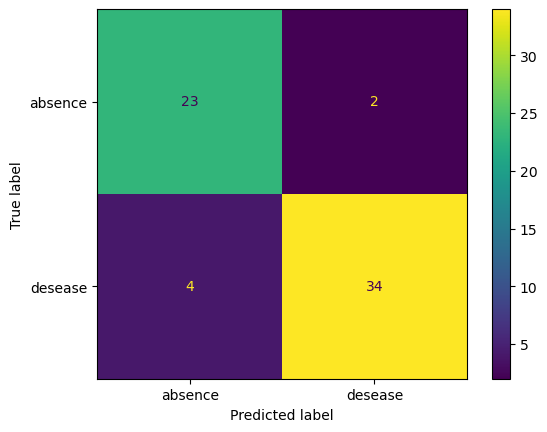

In [97]:
from sklearn import metrics
import matplotlib.pyplot as plt

df_prd = prd.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd['label'], df_prd['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['absence','desease'])
cm_display.plot()
plt.show()

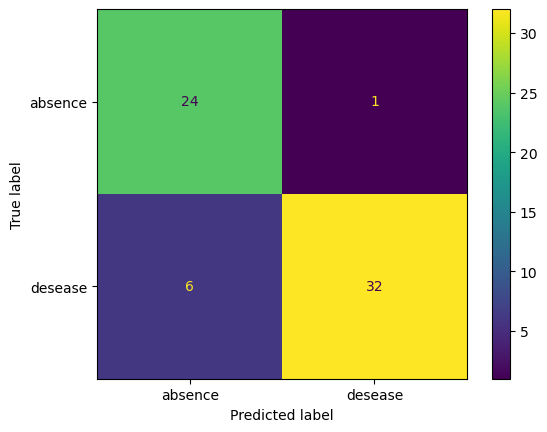

In [99]:
df_prd2 = prd2.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd2['label'], df_prd2['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['absence','desease'])
cm_display.plot()
plt.show()